In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.classification import SAXVSM
from pyts.bag_of_words import BagOfWords
from pyts.datasets import load_gunpoint
from pyts.transformation import ShapeletTransform
from pyts.approximation import SymbolicAggregateApproximation
from scipy.stats import norm
import matplotlib.lines as mlines
from pyts.transformation import BagOfPatterns

## Symbolic Aggregate approXimation in Vector Space Model (SAX-VSM)¶

In [4]:
# Toy dataset
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [5]:
# SAXVSM transformation
saxvsm = SAXVSM(window_size=15, word_size=3, n_bins=2,
                strategy='uniform')
saxvsm.fit(X_train, y_train)
tfidf = saxvsm.tfidf_
vocabulary_length = len(saxvsm.vocabulary_)
X_new = saxvsm.decision_function(X_test)

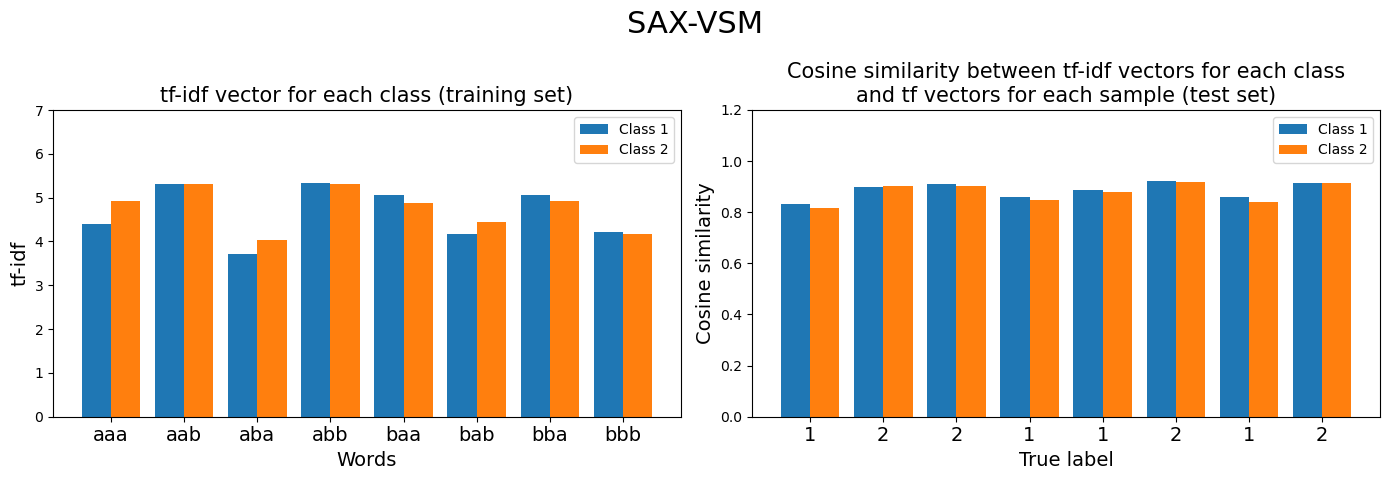

In [6]:
# Visualize the transformation
plt.figure(figsize=(14, 5))
width = 0.4

plt.subplot(121)
plt.bar(np.arange(vocabulary_length) - width / 2, tfidf[0],
        width=width, label='Class 1')
plt.bar(np.arange(vocabulary_length) + width / 2, tfidf[1],
        width=width, label='Class 2')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(saxvsm.vocabulary_.get)(np.arange(vocabulary_length)),
           fontsize=14)
plt.ylim((0, 7))
plt.xlabel("Words", fontsize=14)
plt.ylabel("tf-idf", fontsize=14)
plt.title("tf-idf vector for each class (training set)", fontsize=15)
plt.legend(loc='best')

plt.subplot(122)
n_samples_plot = 8
plt.bar(np.arange(n_samples_plot) - width / 2, X_new[:n_samples_plot, 0],
        width=width, label='Class 1')
plt.bar(np.arange(n_samples_plot) + width / 2, X_new[:n_samples_plot, 1],
        width=width, label='Class 2')
plt.xticks(np.arange(n_samples_plot), y_test[:n_samples_plot], fontsize=14)
plt.ylim((0, 1.2))
plt.xlabel("True label", fontsize=14)
plt.ylabel("Cosine similarity", fontsize=14)
plt.title(("Cosine similarity between tf-idf vectors for each class\n"
           "and tf vectors for each sample (test set)"), fontsize=15)
plt.legend(loc='best')

plt.suptitle("SAX-VSM", y=0.95, fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

Binning continuous data into intervals can be seen as an approximation that reduces noise and captures the trend of a time series. The Symbolic Aggregate approXimation (SAX) algorithm bins continuous time series into intervals, transforming independently each time series (a sequence of floats) into a sequence of symbols, usually letters. This example illustrates the transformation

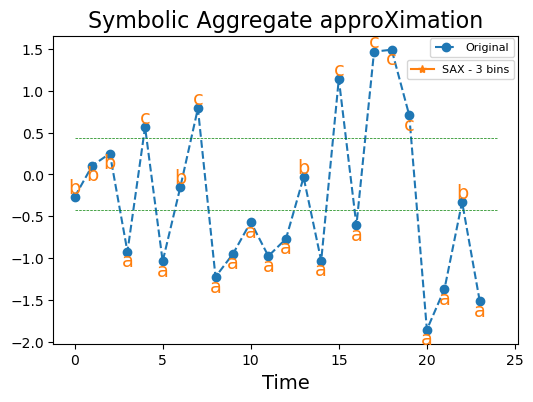

In [20]:
# Parameters
n_samples, n_timestamps = 100, 24

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_timestamps)

# SAX transformation
n_bins = 3
sax = SymbolicAggregateApproximation(n_bins=n_bins, strategy='normal')
X_sax = sax.fit_transform(X)

# Compute gaussian bins
bins = norm.ppf(np.linspace(0, 1, n_bins + 1)[1:-1])

# Show the results for the first time series
bottom_bool = np.r_[True, X_sax[0, 1:] > X_sax[0, :-1]]

plt.figure(figsize=(6, 4))
plt.plot(X[0], 'o--', label='Original')
for x, y, s, bottom in zip(range(n_timestamps), X[0], X_sax[0], bottom_bool):
    va = 'bottom' if bottom else 'top'
    plt.text(x, y, s, ha='center', va=va, fontsize=14, color='#ff7f0e')
plt.hlines(bins, 0, n_timestamps, color='g', linestyles='--', linewidth=0.5)
sax_legend = mlines.Line2D([], [], color='#ff7f0e', marker='*',
                           label='SAX - {0} bins'.format(n_bins))
first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
ax = plt.gca().add_artist(first_legend)
plt.legend(loc=(0.81, 0.93), fontsize=8)
plt.xlabel('Time', fontsize=14)
plt.title('Symbolic Aggregate approXimation', fontsize=16)
plt.show()

## Bag of Words


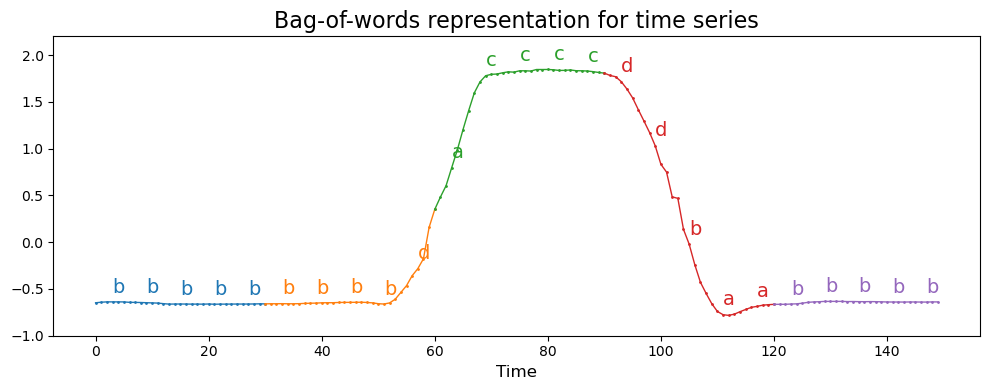

In [9]:
# Load the dataset and perform the transformation
X, _, _, _ = load_gunpoint(return_X_y=True)
window_size, word_size = 30, 5
bow = BagOfWords(window_size=window_size, word_size=word_size,
                 window_step=window_size, numerosity_reduction=False)
X_bow = bow.transform(X)

# Plot the considered subseries
plt.figure(figsize=(10, 4))
splits_series = np.linspace(0, X.shape[1], 1 + X.shape[1] // window_size,
                            dtype='int64')
for start, end in zip(splits_series[:-1],
                      np.clip(splits_series[1:] + 1, 0, X.shape[1])):
    plt.plot(np.arange(start, end), X[0, start:end], 'o-', lw=1, ms=1)

# Plot the corresponding letters
splits_letters = np.linspace(0, X.shape[1],
                             1 + word_size * X.shape[1] // window_size)
splits_letters = (
    (splits_letters[:-1] + splits_letters[1:]) / 2).astype('int64')
for i, (x, text) in enumerate(zip(splits_letters, X_bow[0].replace(' ', ''))):
    plt.text(x, X[0, x] + 0.1, text, color="C{}".format(i // 5), fontsize=14)

plt.ylim((-1, 2.2))
plt.xlabel('Time', fontsize=12)
plt.title('Bag-of-words representation for time series', fontsize=16)
plt.tight_layout()
plt.show()

## Shapelet Transform


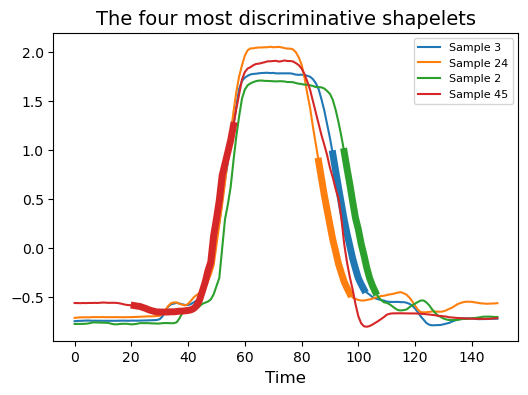

In [13]:

# Toy dataset
X_train, _, y_train, _ = load_gunpoint(return_X_y=True)

# Shapelet transformation
st = ShapeletTransform(window_sizes=[12, 24, 36, 48],
                       random_state=42, sort=True)
X_new = st.fit_transform(X_train, y_train)

# Visualize the four most discriminative shapelets
plt.figure(figsize=(6, 4))
for i, index in enumerate(st.indices_[:4]):
    idx, start, end = index
    plt.plot(X_train[idx], color='C{}'.format(i),
             label='Sample {}'.format(idx))
    plt.plot(np.arange(start, end), X_train[idx, start:end],
             lw=5, color='C{}'.format(i))

plt.xlabel('Time', fontsize=12)
plt.title('The four most discriminative shapelets', fontsize=14)
plt.legend(loc='best', fontsize=8)
plt.show()

## Bag of Patterns

Bag-of-words approaches are common in time series classification. The Bag-of-patterns algorithm uses a sliding window to extract subsequences from the time series and transforms each subsequence into a word using the Piecewise Aggregate Approximation and the Symbolic Aggregate approXimation algorithms. Thus it transforms each time series into a bag of words. Then it derives the frequencies of each word for each time series.

This example illustrates the words and the frequencies of these words that have been learned by this algorithm. It is implemented as pyts.transformation.BagOfPatterns.

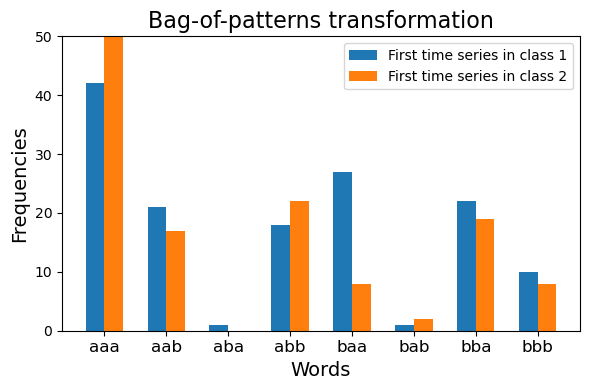

In [22]:
# Toy dataset
X_train, _, y_train, _ = load_gunpoint(return_X_y=True)

# BOSS transformation
bop = BagOfPatterns(window_size=9, word_size=3, n_bins=2,
                    numerosity_reduction=False, sparse=False)
X_bop = bop.fit_transform(X_train)

# Visualize the transformation for the first time series
plt.figure(figsize=(6, 4))
vocabulary_length = len(bop.vocabulary_)
width = 0.3
plt.bar(np.arange(vocabulary_length) - width / 2, X_bop[y_train == 1][0],
        width=width, label='First time series in class 1')
plt.bar(np.arange(vocabulary_length) + width / 2, X_bop[y_train == 2][0],
        width=width, label='First time series in class 2')
plt.xticks(np.arange(vocabulary_length),
           np.vectorize(bop.vocabulary_.get)(np.arange(X_bop[0].size)),
           fontsize=12)
y_max = np.max(np.concatenate([X_bop[y_train == 1][0],
                               X_bop[y_train == 2][0]]))
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequencies", fontsize=14)
plt.title("Bag-of-patterns transformation", fontsize=16)
plt.legend(loc='best', fontsize=10)
plt.ylim((0, 50))
plt.tight_layout()
plt.show()